# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
gene_df = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
fea_df = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
gene_df.shape

(891221, 85)

In [4]:
gene_df.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


In [5]:
fea_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


In [6]:
fea_df.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
cus_df = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
cus_df.head(3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.
# identify the missing_or_unknown vlaue for each attribute

import ast

def safe_literal_eval(val):
    try:
        # Parse string into Python literal if possible
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []
        
# Ensure that all values in 'missing_or_unknown' are evaluated into their correct form
fea_df['missing_or_unknown'] = fea_df['missing_or_unknown'].apply(safe_literal_eval)

map = {}
for feature in fea_df['attribute']:
    # print(feature, "Missing value shown as:")
    # print(fea_df[fea_df['attribute'] == feature]['missing_or_unknown'])
    value = fea_df[fea_df['attribute'] == feature]['missing_or_unknown'].iloc[0]
    # print(type(value))
    map[feature] = value

In [9]:
# orignal Nan value
gene_df.isna().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [10]:
count = (gene_df['RELAT_AB'].isin([-1,9])).sum()
count

159

In [11]:
# convert them to NaNs
new_df = gene_df.copy()
for key, value in map.items():
    print(key)
    mask = new_df[key].isin(value)
    print(new_df.loc[mask, key].sum())
    new_df.loc[mask, key] = np.nan

AGER_TYP
-677503
ALTERSKATEGORIE_GROB
25929
ANREDE_KZ
0
CJT_GESAMTTYP
0.0
FINANZ_MINIMALIST
0
FINANZ_SPARER
0
FINANZ_VORSORGER
0
FINANZ_ANLEGER
0
FINANZ_UNAUFFAELLIGER
0
FINANZ_HAUSBAUER
0
FINANZTYP
0
GEBURTSJAHR
0
GFK_URLAUBERTYP
0.0
GREEN_AVANTGARDE
0
HEALTH_TYP
-111196
LP_LEBENSPHASE_FEIN
0.0
LP_LEBENSPHASE_GROB
0.0
LP_FAMILIE_FEIN
0.0
LP_FAMILIE_GROB
0.0
LP_STATUS_FEIN
0.0
LP_STATUS_GROB
0.0
NATIONALITAET_KZ
0
PRAEGENDE_JUGENDJAHRE
0
RETOURTYP_BK_S
0.0
SEMIO_SOZ
0
SEMIO_FAM
0
SEMIO_REL
0
SEMIO_MAT
0
SEMIO_VERT
0
SEMIO_LUST
0
SEMIO_ERL
0
SEMIO_KULT
0
SEMIO_RAT
0
SEMIO_KRIT
0
SEMIO_DOM
0
SEMIO_KAEM
0
SEMIO_PFLICHT
0
SEMIO_TRADV
0
SHOPPER_TYP
-111196
SOHO_KZ
0.0
TITEL_KZ
0.0
VERS_TYP
-111196
ZABEOTYP
0
ALTER_HH
0.0
ANZ_PERSONEN
0.0
ANZ_TITEL
0.0
HH_EINKOMMEN_SCORE
0.0
KK_KUNDENTYP
0.0
W_KEIT_KIND_HH
0.0
WOHNDAUER_2008
0.0
ANZ_HAUSHALTE_AKTIV
0.0
ANZ_HH_TITEL
0.0
GEBAEUDETYP
0.0
KONSUMNAEHE
0.0
MIN_GEBAEUDEJAHR
0.0
OST_WEST_KZ
0
WOHNLAGE
0.0
CAMEO_DEUG_2015
0
CAMEO_DEU_2015
0
CAMEO_INT

In [12]:
count = (new_df['RELAT_AB'].isin([-1,9])).sum()
count

0

In [13]:
# observe new number of nans
new_df.isna().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# the proportion of missing value 
missing_prop = new_df.isna().mean()
print(missing_prop)

AGER_TYP                 0.769554
ALTERSKATEGORIE_GROB     0.003233
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.005446
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
FINANZTYP                0.000000
GEBURTSJAHR              0.440203
GFK_URLAUBERTYP          0.005446
GREEN_AVANTGARDE         0.000000
HEALTH_TYP               0.124768
LP_LEBENSPHASE_FEIN      0.109549
LP_LEBENSPHASE_GROB      0.106115
LP_FAMILIE_FEIN          0.087287
LP_FAMILIE_GROB          0.087287
LP_STATUS_FEIN           0.005446
LP_STATUS_GROB           0.005446
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
RETOURTYP_BK_S           0.005446
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
SEMIO_REL                0.000000
SEMIO_MAT                0.000000
SEMIO_VERT               0.000000
SEMIO_LUST    

In [15]:
# plot only the columns with missing values
mask = missing_prop>0
missing_prop[mask].count()

61

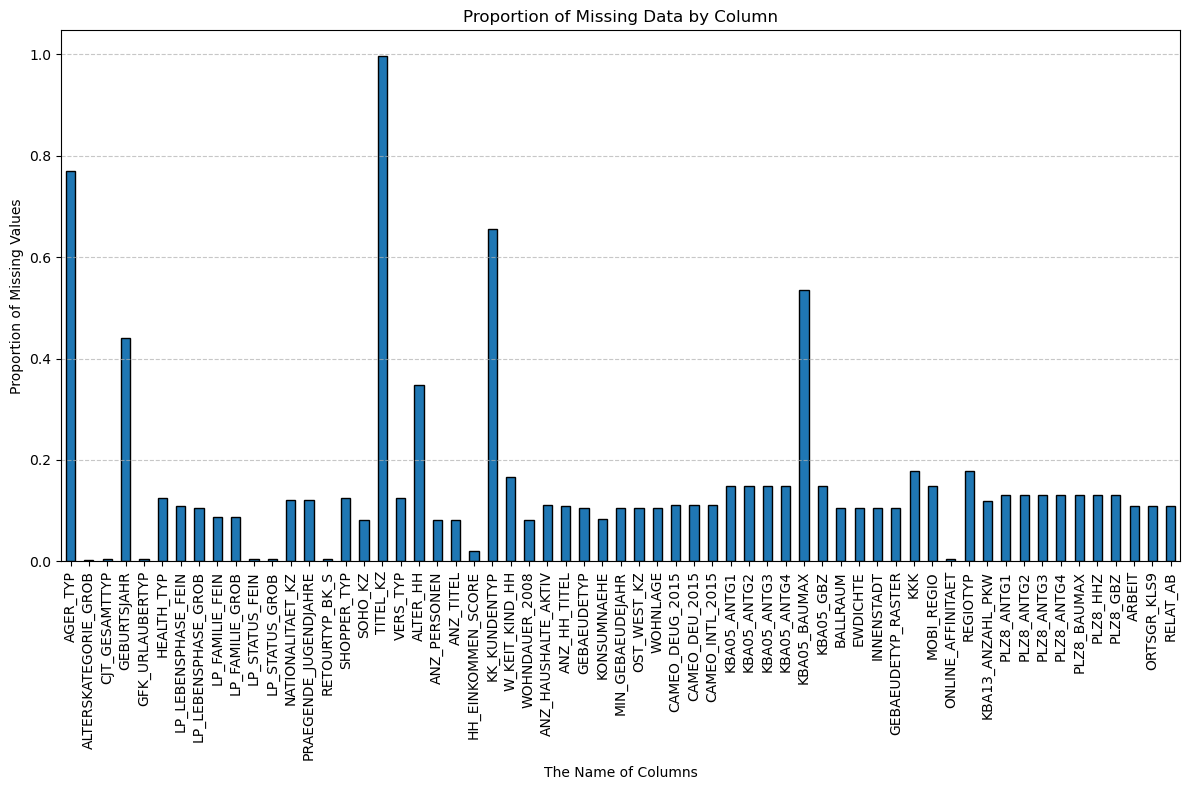

In [16]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(12, 8))
missing_prop[mask].plot(kind='bar',  edgecolor='k')
plt.title('Proportion of Missing Data by Column')
plt.xlabel('The Name of Columns')
plt.ylabel('Proportion of Missing Values')
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
threshold = 0.3
mask = missing_prop>threshold
col_drop = missing_prop[mask].index
print(f"Columns to drop ({len(col_drop)}): {list(col_drop)}")

cleaned_df = new_df.drop(columns=col_drop)

Columns to drop (6): ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [18]:
cleaned_df.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

After analyzing the missing data proportions, several columns were identified as outliers with a high proportion of missing values (above 30%). Notable columns removed include ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']. These columns were removed to improve data quality and analysis reliability. Among them, `'AGER_TYP', 'GEBURTSJAHR' and 'ALTER_HH'` are all related to the age of a customer  accodeing to the description of this data set.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

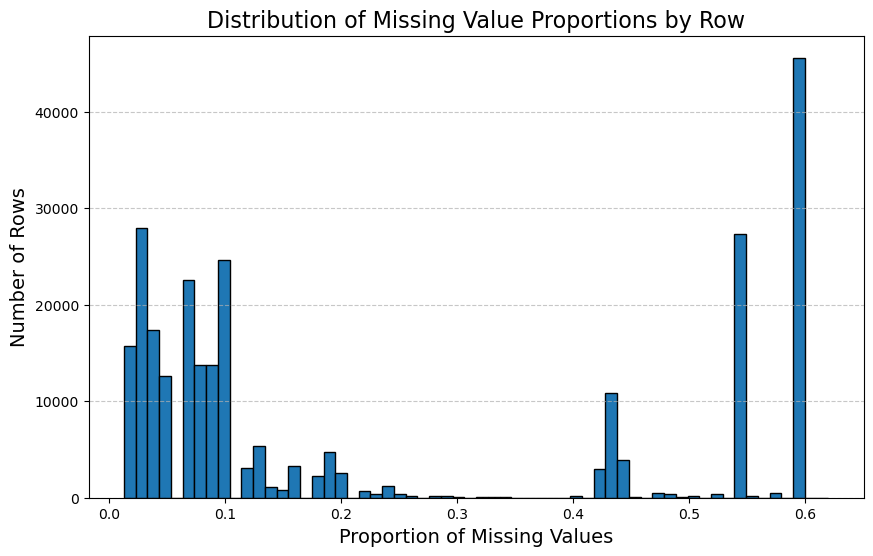

In [19]:
# How much data is missing in each row of the dataset?
row_missing_prop = cleaned_df.isna().mean(axis=1)
mask  = row_missing_prop>0   # show only the rows contain missing data

# visualize the distribution of proportion of missing values for each row
plt.figure(figsize=(10, 6))
plt.hist(row_missing_prop[mask], bins=60, edgecolor='k')
plt.title('Distribution of Missing Value Proportions by Row', fontsize=16)
plt.xlabel('Proportion of Missing Values', fontsize=14)
plt.ylabel('Number of Rows', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshold = 0.1
high_missing = cleaned_df[row_missing_prop > threshold]
low_missing = cleaned_df[row_missing_prop <= threshold]

print(f"High-missing rows: {len(high_missing)}")
print(f"Low-missing rows: {len(low_missing)}")


High-missing rows: 144059
Low-missing rows: 747162


In [21]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Function to compare distributions for a given column
def compare_distributions(column):
    plt.figure(figsize=(12, 6))

    # Low-missing subset
    plt.subplot(1, 2, 1)
    sns.countplot(x=low_missing[column], order=low_missing[column].value_counts().index, palette='Greens', hue=low_missing[column])
    plt.title(f'Low Missing: {column}', fontsize=14)
    plt.xticks(rotation=45)

    # High-missing subset
    plt.subplot(1, 2, 2)
    sns.countplot(x=high_missing[column], order=low_missing[column].value_counts().index, palette='Reds', hue=high_missing[column])
    plt.title(f'High Missing: {column}', fontsize=14)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


In [22]:
missing_col = cleaned_df.isna().mean()
print("columns that are not missing data:\n", missing_col[missing_col<0.05].index)
# to choose the five columns for comparison

columns that are not missing data:
 Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP', 'HH_EINKOMMEN_SCORE',
       'ONLINE_AFFINITAET'],
      dtype='object')


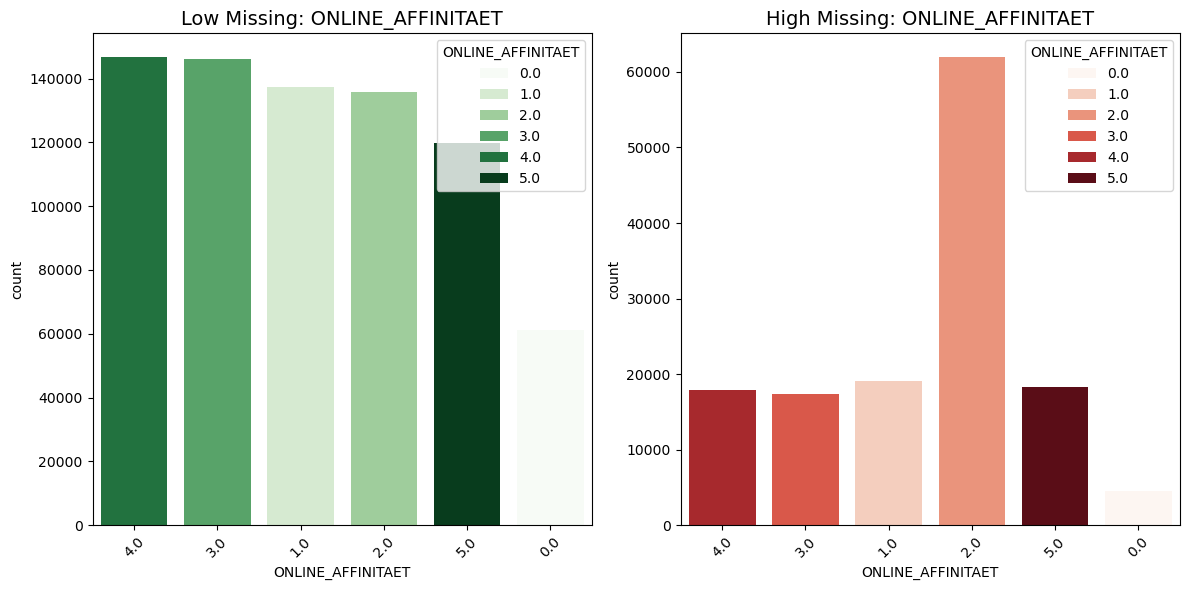

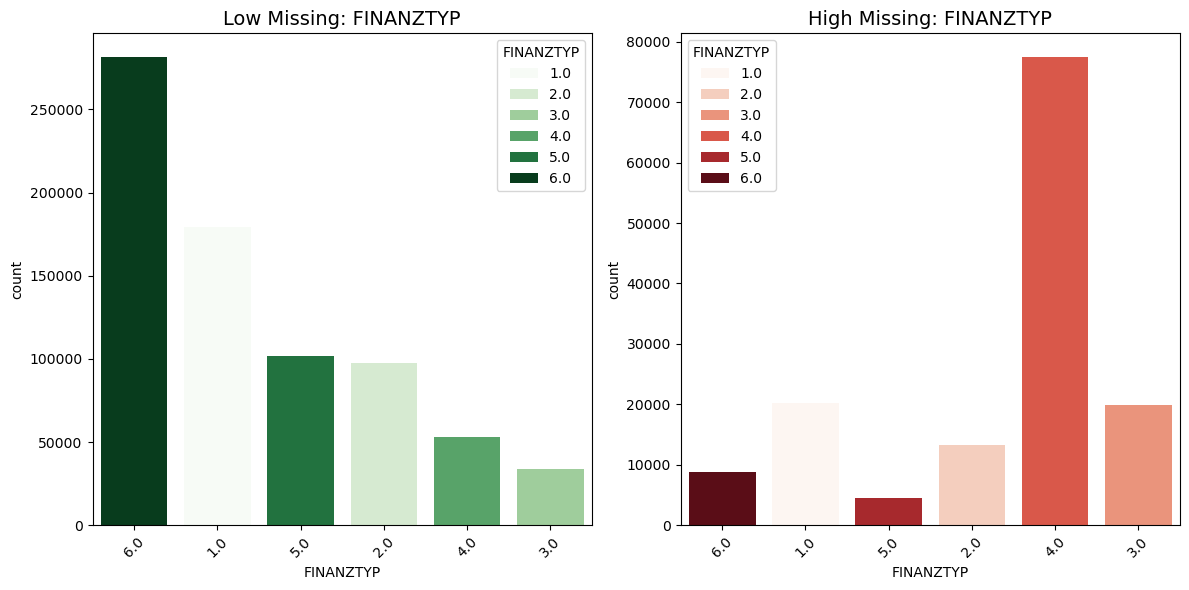

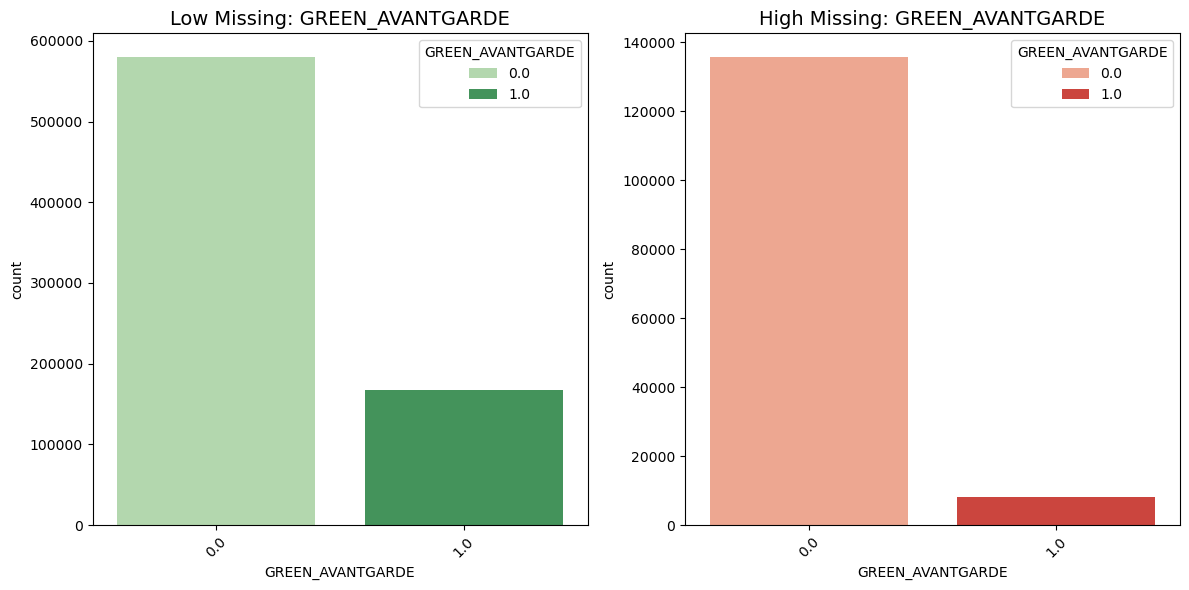

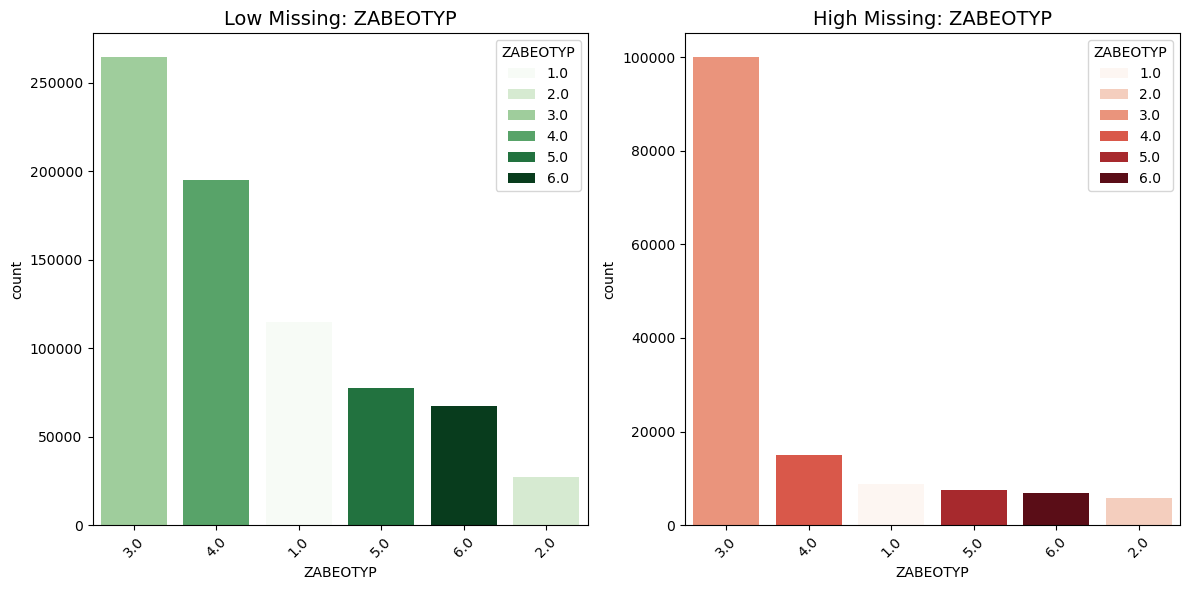

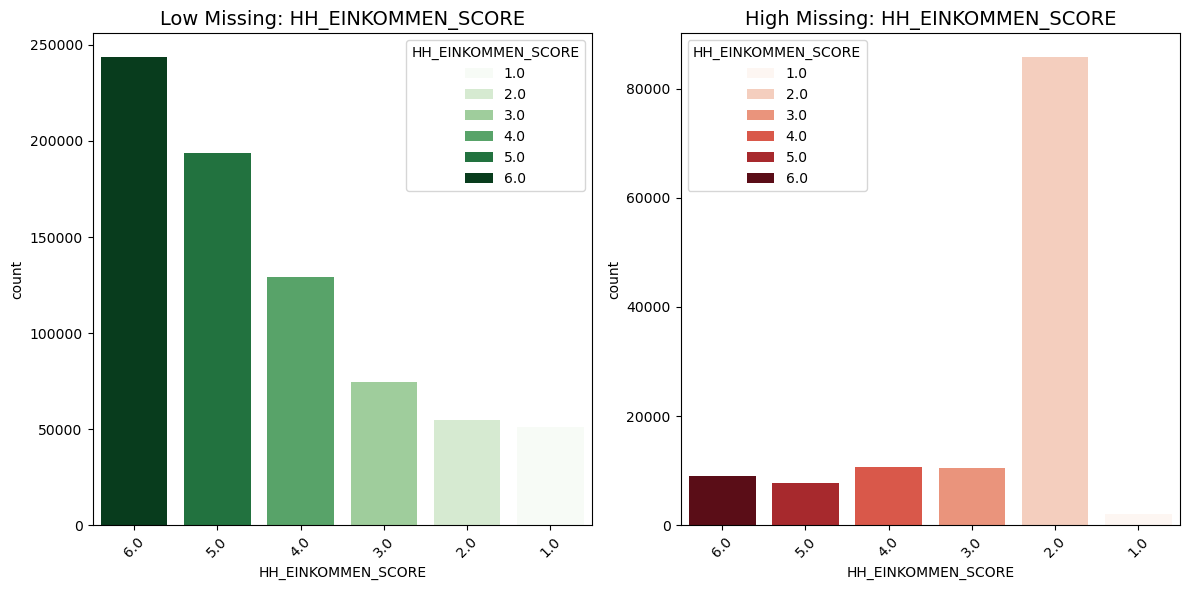

In [23]:
# Compare five columns
columns_to_compare = ['ONLINE_AFFINITAET', 'FINANZTYP', 'GREEN_AVANTGARDE', 'ZABEOTYP', 'HH_EINKOMMEN_SCORE']
for col in columns_to_compare:
    if col in low_missing.columns and col in high_missing.columns:
        compare_distributions(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

From the above count plots, we can observe that in the selected five features(with no or much fewer missing values), most of them(4 out of 5) shows totally different distributions in the two groups of data.\ 
This might indicates that the rows with a high proportion of missing data represent a distinct subset of the population with different characteristics. So simply dropping rows with high missing values could potentially lead to a loss of important or distinct information. 

In [24]:
print(cleaned_df.shape)
cleaned_df = low_missing
print(cleaned_df.shape)

(891221, 79)
(747162, 79)


In [25]:
# check if there is any missing value
print(cleaned_df.isna().any())

ALTERSKATEGORIE_GROB      True
ANREDE_KZ                False
CJT_GESAMTTYP            False
FINANZ_MINIMALIST        False
FINANZ_SPARER            False
FINANZ_VORSORGER         False
FINANZ_ANLEGER           False
FINANZ_UNAUFFAELLIGER    False
FINANZ_HAUSBAUER         False
FINANZTYP                False
GFK_URLAUBERTYP          False
GREEN_AVANTGARDE         False
HEALTH_TYP                True
LP_LEBENSPHASE_FEIN       True
LP_LEBENSPHASE_GROB       True
LP_FAMILIE_FEIN           True
LP_FAMILIE_GROB           True
LP_STATUS_FEIN           False
LP_STATUS_GROB           False
NATIONALITAET_KZ          True
PRAEGENDE_JUGENDJAHRE     True
RETOURTYP_BK_S           False
SEMIO_SOZ                False
SEMIO_FAM                False
SEMIO_REL                False
SEMIO_MAT                False
SEMIO_VERT               False
SEMIO_LUST               False
SEMIO_ERL                False
SEMIO_KULT               False
SEMIO_RAT                False
SEMIO_KRIT               False
SEMIO_DO

In [26]:
# handling missing value
cleaned_df.fillna(method='bfill', inplace=True)
print(cleaned_df.isna().any().sum())

C:\Users\Zhan\AppData\Local\Temp\ipykernel_5124\1549051115.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_df.fillna(method='bfill', inplace=True)


0


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# How many features are there of each data type?
fea_df.iloc[:, 2].value_counts()

type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
mask = fea_df['type'] == 'categorical'
cate_features = fea_df[mask].attribute
print("All categorical features:\n", cate_features)


All categorical features:
 0             AGER_TYP
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
40            TITEL_KZ
41            VERS_TYP
42            ZABEOTYP
47        KK_KUNDENTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object


In [29]:
# Initialize categories
binary_features = []
multi_level_features = []

# Analyze each categorical feature
for feature in cate_features:
    if feature in cleaned_df.columns:  # check if the feature is already been removed
        unique_values = cleaned_df[feature].nunique()
        # print(f"\nFeature: {feature}")
        # print(cleaned_df[feature].value_counts())
    
        # Classify the feature
        if unique_values == 2:
            binary_features.append(feature)
        else:
            multi_level_features.append(feature)

# Print results
print("\nBinary Features:", binary_features)
print("Multi-level Features:", multi_level_features)



Binary Features: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-level Features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.

# investigate the values of binary featurs

for feature in binary_features:
    unique_values = cleaned_df[feature].nunique()
    print(f"\nFeature: {feature}")
    print(cleaned_df[feature].value_counts())


Feature: ANREDE_KZ
ANREDE_KZ
2.0    387716
1.0    359446
Name: count, dtype: int64

Feature: GREEN_AVANTGARDE
GREEN_AVANTGARDE
0.0    580223
1.0    166939
Name: count, dtype: int64

Feature: SOHO_KZ
SOHO_KZ
0.0    740897
1.0      6265
Name: count, dtype: int64

Feature: VERS_TYP
VERS_TYP
2.0    394845
1.0    352317
Name: count, dtype: int64

Feature: OST_WEST_KZ
OST_WEST_KZ
W    587552
O    159610
Name: count, dtype: int64


In [31]:
# handling the nun-numeric input of 'OST_WEST_KZ'
### 3.6. OST_WEST_KZ
# Building location via former East / West Germany (GDR / FRG)
# - -1: unknown
# -  O: East (GDR)
# -  W: West (FRG)

# replace specific values
cleaned_df['OST_WEST_KZ'] = cleaned_df['OST_WEST_KZ'].replace({'O': 1,
                                                            'W': 2})
cleaned_df['OST_WEST_KZ'].value_counts()

OST_WEST_KZ
2    587552
1    159610
Name: count, dtype: int64

In [32]:
# investigate the values of binary featurs
drop_mul_features = []
for feature in multi_level_features:
    unique_values = cleaned_df[feature].nunique()
    print(f"\nFeature: {feature}")
    print(cleaned_df[feature].value_counts())
    if unique_values > 10:
        drop_mul_features.append(feature)

print("Multi-level Featureswith more than 10 unique values:", drop_mul_features)


Feature: CJT_GESAMTTYP
CJT_GESAMTTYP
4.0    187636
3.0    139143
2.0    137056
5.0    100851
6.0     93675
1.0     88801
Name: count, dtype: int64

Feature: FINANZTYP
FINANZTYP
6.0    281625
1.0    179316
5.0    101989
2.0     97629
4.0     53114
3.0     33489
Name: count, dtype: int64

Feature: GFK_URLAUBERTYP
GFK_URLAUBERTYP
12.0    119652
10.0     97722
8.0      79665
11.0     71369
5.0      68304
4.0      59038
9.0      52751
3.0      51336
1.0      48349
7.0      38655
2.0      35571
6.0      24750
Name: count, dtype: int64

Feature: LP_FAMILIE_FEIN
LP_FAMILIE_FEIN
1.0     390526
10.0    128115
2.0      96723
11.0     48524
8.0      20975
7.0      17777
4.0      11204
5.0      10956
9.0      10372
6.0       7586
3.0       4404
Name: count, dtype: int64

Feature: LP_FAMILIE_GROB
LP_FAMILIE_GROB
1.0    390526
5.0    187011
2.0     96723
4.0     46338
3.0     26564
Name: count, dtype: int64

Feature: LP_STATUS_FEIN
LP_STATUS_FEIN
1.0     201599
9.0     123727
10.0    106975
2.0     

In [33]:
# handling multi-level features
# drop the features with more than 10 unique values
print(cleaned_df.shape)
cleaned_df.drop(drop_mul_features, axis=1, inplace=True)
print(cleaned_df.shape)

(747162, 79)
(747162, 76)


In [34]:
# handling remaining multi-level features
rem_mul_features = [f for f in multi_level_features if f not in drop_mul_features]
print('CAMEO_DEU_2015' in rem_mul_features) #check if successfully drop the columns

# applying one hot encoding
encoder = OneHotEncoder()
encoded_df = pd.get_dummies(cleaned_df, columns=rem_mul_features)

print(encoded_df.shape[1])

False
128


In [35]:
encoded_df.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEUG_2015_1', 'CAMEO_DEUG_2015_2', 'CAMEO_DEUG_2015_3',
       'CAMEO_DEUG_2015_4', 'CAMEO_DEUG_2015_5', 'CAMEO_DEUG_2015_6',
       'CAMEO_DEUG_2015_7', 'CAMEO_DEUG_2015_8', 'CAMEO_DEUG_2015_9',
       'CAMEO_DEUG_2015_X'],
      dtype='object', length=128)

#### Discussion 1.2.1: Re-Encode Categorical Features

- For the binary variable that takes on non-numeric values, I replace the letters with number (`{'O': 1, 'W': 2}`).- 
For multi-level categoricals (three or more values:
    - I drop the features with more than 10 unique values: `['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'CAMEO_DEU_2015']`.
    - apply one hot encoder in the remaining multi-level categorical features..

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
encoded_df['PRAEGENDE_JUGENDJAHRE'].value_counts()

PRAEGENDE_JUGENDJAHRE
14.0    176891
8.0     137157
5.0      83533
10.0     82446
3.0      52930
15.0     40391
11.0     33912
9.0      33133
6.0      25643
12.0     23785
4.0      20453
1.0      20053
2.0       7476
13.0      5401
7.0       3958
Name: count, dtype: int64

In [37]:
# Map each category to its corresponding decade
decade_mapping = {
    1: 40, 2: 40,
    3: 50, 4: 50,
    5: 60, 6: 60, 7: 60,
    8: 70, 9: 70,
    10: 80, 11: 80, 12: 80, 13: 80,
    14: 90, 15: 90,
    -1: None, 0: None
}

encoded_df['Decade'] = encoded_df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
encoded_df['Decade'].value_counts()

Decade
90.0    217282
70.0    170290
80.0    145544
60.0    113134
50.0     73383
40.0     27529
Name: count, dtype: int64

In [38]:
# Map each category to its corresponding movement type
movement_mapping = {
    1: 0, 2: 1,
    3: 0, 4: 1,
    5: 0, 6: 1, 7: 1,
    8: 0, 9: 1,
    10: 0, 11: 1, 12: 0, 13: 1,
    14: 0, 15: 1,
    -1: None, 0: None
}

# Apply the mapping to create a new column for movement
encoded_df['Movement'] = encoded_df['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)
print(encoded_df['Movement'].value_counts())
print(encoded_df[['PRAEGENDE_JUGENDJAHRE', 'Decade', 'Movement']].head())

Movement
0.0    576795
1.0    170367
Name: count, dtype: int64
   PRAEGENDE_JUGENDJAHRE  Decade  Movement
1                   14.0    90.0       0.0
2                   15.0    90.0       1.0
3                    8.0    70.0       0.0
4                    8.0    70.0       0.0
5                    3.0    50.0       0.0


In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
encoded_df['CAMEO_INTL_2015'].value_counts()

CAMEO_INTL_2015
51    128513
41     88236
24     86076
14     59257
43     54262
54     43842
25     37756
22     30702
45     25253
13     24628
55     22796
23     20407
52     19697
34     17615
15     16355
31     16347
44     14169
12     12024
35      9937
32      9809
33      9182
XX       299
Name: count, dtype: int64

In [40]:
encoded_df['CAMEO_INTL_2015'] = encoded_df['CAMEO_INTL_2015'].astype(str)

encoded_df['CAMEO_INTL_2015'] = encoded_df['CAMEO_INTL_2015'].replace({'-1': np.nan, 'XX': np.nan})  #-1 or XX are unkown value
encoded_df['CAMEO_INTL_2015'].bfill(inplace=True)

encoded_df['Wealth'] = encoded_df['CAMEO_INTL_2015'].str[0].astype(float)
encoded_df['Life_Stage'] = encoded_df['CAMEO_INTL_2015'].str[1].astype(float)

In [41]:
print(encoded_df.isna().any().sum())
print(encoded_df.shape)
# drop two original columns
encoded_df.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis=True, inplace=True)
print(encoded_df.shape)

0
(747162, 132)
(747162, 130)


In [42]:
print(encoded_df[['Wealth', 'Life_Stage']].head(3))

   Wealth  Life_Stage
1     5.0         1.0
2     2.0         4.0
3     1.0         2.0


In [43]:
fea_df['type'].value_counts()

type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64

In [44]:
#investigate other mixed features
mixed_features = fea_df[fea_df['type'] == 'mixed'].attribute
for feature in mixed_features:
    if feature in encoded_df.columns:
        print(encoded_df[feature].value_counts())

LP_LEBENSPHASE_FEIN
1.0     59938
5.0     53820
6.0     44026
2.0     38038
8.0     29237
7.0     25676
29.0    25594
13.0    25256
11.0    23810
31.0    22985
10.0    22590
12.0    21448
30.0    21119
15.0    19536
3.0     18766
19.0    17611
4.0     16925
37.0    16918
20.0    16646
14.0    16510
32.0    16138
39.0    15499
40.0    14638
16.0    13880
38.0    12987
35.0    12961
21.0    12264
34.0    11922
9.0     11852
24.0    11604
27.0    11522
28.0    10960
36.0     9828
25.0     9630
23.0     7814
22.0     6823
18.0     5928
33.0     5779
17.0     5490
26.0     3194
Name: count, dtype: int64
LP_LEBENSPHASE_GROB
2.0     152211
1.0     133158
3.0     105088
12.0     69635
4.0      51889
9.0      46525
5.0      45556
10.0     38994
11.0     30538
6.0      26811
8.0      25607
7.0      21150
Name: count, dtype: int64
WOHNLAGE
3.0    238004
7.0    162597
4.0    128811
2.0     95423
5.0     68889
1.0     41805
8.0     11502
0.0       131
Name: count, dtype: int64
PLZ8_BAUMAX
1.0    47

In [45]:
# LP_LEBENSPHASE_GROB: Life stage, rough scale; LP_LEBENSPHASE_FEIN: Life stage, fine scale
# drop LP_LEBENSPHASE_FEIN, since it contains to many unique values 
# using LP_LEBENSPHASE_GROB instead
print(encoded_df.shape)
# drop two original columns
encoded_df.drop(['LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)
print(encoded_df.shape)

(747162, 130)
(747162, 129)


In [46]:
# Since the categories are nominal in nature, apply One-Hot Encoding on 'LP_LEBENSPHASE_GROB'
print(encoded_df.shape)
one_hot = pd.get_dummies(encoded_df['LP_LEBENSPHASE_GROB'],
                                 prefix = 'LP_LEBENSPHASE_GROB')
completed_df = pd.concat([encoded_df, one_hot], axis=1)
completed_df.drop(columns=['LP_LEBENSPHASE_GROB'], inplace=True)
print(completed_df.shape)

(747162, 129)
(747162, 140)


#### Discussion 1.2.2: Engineer Mixed-Type Features
I apply required trasformation on "PRAEGENDE_JUGENDJAHRE"  and  "CAMEO_INTL_2015". For "PRAEGENDE_JUGENDJAHRE" I create two new variables to capture the other two dimensions: an interval-type variable for decade by `Decade`, and a binary variable for movement by `Movement`. And for "CAMEO_INTL_2015", I code it to two new features `['Wealth', 'Life_Stage']`. After that, I also drop two original features.

And for other mixed features:

1. OHNLAGE: Neighborhood quality (or rural flag)
    - -1: unknown
    -  0: no score calculated
    -  1: very good neighborhood
    -  2: good neighborhood
    -  3: average neighborhood
    -  4: poor neighborhood
    -  5: very poor neighborhood
    -  7: rural neighborhood
    -  8: new building in rural neighborhood
Since  it represents an ordinal variable with an inherent order of quality (from "very good neighborhood" to "very poor neighborhood"), I will leave it unchanged.

2. PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region
    - -1: unknown
    -  0: no 1-2 family homes
    -  1: lower share of 1-2 family homes
    -  2: average share of 1-2 family homes
    -  3: high share of 1-2 family homes
    -  4: very high share of 1-2 family homes
Since  it also represents an ordinal variable with an inherent order of quality (from "no family homes" to "very high share of family homes"), I will leave it unchanged.

3. LP_LEBENSPHASE_GROB: Life stage, rough scale; LP_LEBENSPHASE_FEIN: Life stage, fine scale.
I choose to drop `LP_LEBENSPHASE_FEIN`, since it contains to many unique values and has almost the same meaning as `LP_LEBENSPHASE_GROB`. Since the categories are nominal in nature, I apply One-Hot Encoding on `LP_LEBENSPHASE_GROB`.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [47]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
print(gene_df.shape)
print(completed_df.shape)

(891221, 85)
(747162, 140)


In [48]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
ori_cols = set(gene_df.columns)
final_cols = set(completed_df.columns)

# Compare columns
only_in_df1 = ori_cols - final_cols
only_in_df2 = final_cols - ori_cols
common_columns = ori_cols & final_cols

print("Columns only in original df:", only_in_df1)
print("Columns only in pre-processed df:", only_in_df2)
print("Common columns:", common_columns)

Columns only in original df: {'PRAEGENDE_JUGENDJAHRE', 'FINANZTYP', 'LP_FAMILIE_GROB', 'CAMEO_DEU_2015', 'LP_STATUS_FEIN', 'GEBURTSJAHR', 'CAMEO_DEUG_2015', 'LP_FAMILIE_FEIN', 'GEBAEUDETYP', 'CJT_GESAMTTYP', 'LP_STATUS_GROB', 'KBA05_BAUMAX', 'GFK_URLAUBERTYP', 'TITEL_KZ', 'SHOPPER_TYP', 'LP_LEBENSPHASE_GROB', 'NATIONALITAET_KZ', 'KK_KUNDENTYP', 'LP_LEBENSPHASE_FEIN', 'AGER_TYP', 'ZABEOTYP', 'ALTER_HH', 'CAMEO_INTL_2015'}
Columns only in pre-processed df: {'LP_STATUS_FEIN_4.0', 'ZABEOTYP_2.0', 'FINANZTYP_1.0', 'SHOPPER_TYP_2.0', 'LP_LEBENSPHASE_GROB_8.0', 'CJT_GESAMTTYP_2.0', 'Decade', 'LP_STATUS_GROB_3.0', 'LP_LEBENSPHASE_GROB_4.0', 'NATIONALITAET_KZ_1.0', 'LP_LEBENSPHASE_GROB_2.0', 'NATIONALITAET_KZ_3.0', 'CAMEO_DEUG_2015_X', 'CAMEO_DEUG_2015_1', 'FINANZTYP_3.0', 'FINANZTYP_4.0', 'CJT_GESAMTTYP_3.0', 'LP_STATUS_FEIN_3.0', 'CAMEO_DEUG_2015_7', 'FINANZTYP_6.0', 'SHOPPER_TYP_3.0', 'CAMEO_DEUG_2015_2', 'LP_STATUS_FEIN_6.0', 'GEBAEUDETYP_5.0', 'LP_LEBENSPHASE_GROB_9.0', 'LP_STATUS_FEIN_7.0

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [49]:
print(col_drop) # cols mit too many missing values
print(drop_mul_features) # Multi-level Featureswith more than 10 unique values
print(rem_mul_features) # other multi-level cate features

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')
['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'CAMEO_DEU_2015']
['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']


In [50]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    map = {}
    for feature in fea_df['attribute']:
        value = fea_df[fea_df['attribute'] == feature]['missing_or_unknown'].iloc[0]
        # print(type(value))
        map[feature] = value
    
    new_df = df.copy()
    for key, value in map.items():
        mask = new_df[key].isin(value)
        new_df.loc[mask, key] = np.nan
        
    # remove selected columns and rows, ...
    # drop columns that contians to many missing value, obtained from above analysis
    col_drop = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    cleaned_df = new_df.drop(columns=col_drop)
    # drop rows that contians to many missing value, obtained from above analysis
    row_missing_prop = cleaned_df.isna().mean(axis=1)
    threshold = 0.1
    low_missing = cleaned_df[row_missing_prop <= threshold]
    cleaned_df = low_missing.bfill()
    
    # select, re-encode, and engineer column values.
    # handling the nun-numeric input of binary feature 'OST_WEST_KZ': replace specific values
    cleaned_df['OST_WEST_KZ'] = cleaned_df['OST_WEST_KZ'].replace({'O': 1,
                                                            'W': 2})
    # handling multi-level features
    # drop the features with more than 10 unique values
    drop_mul_features = ['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'CAMEO_DEU_2015']
    cleaned_df.drop(drop_mul_features, axis=1, inplace=True)
    rem_mul_features = ['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015']
    encoded_df = pd.get_dummies(cleaned_df, columns=rem_mul_features)
    
    # handling mixed fatures
    # PRAEGENDE_JUGENDJAHRE -> Decade, Movement
    decade_mapping = {
        1: 40, 2: 40,
        3: 50, 4: 50,
        5: 60, 6: 60, 7: 60,
        8: 70, 9: 70,
        10: 80, 11: 80, 12: 80, 13: 80,
        14: 90, 15: 90,
        -1: None, 0: None
    }
    encoded_df['Decade'] = encoded_df['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)
    # Map each category to its corresponding movement type
    movement_mapping = {
        1: 0, 2: 1,
        3: 0, 4: 1,
        5: 0, 6: 1, 7: 1,
        8: 0, 9: 1,
        10: 0, 11: 1, 12: 0, 13: 1,
        14: 0, 15: 1,
        -1: None, 0: None
    }
    # Apply the mapping to create a new column for movement
    encoded_df['Movement'] = encoded_df['PRAEGENDE_JUGENDJAHRE'].map(movement_mapping)
    
    # CAMEO_INTL_2015 -> Welth, Life_Stage
    encoded_df['CAMEO_INTL_2015'] = encoded_df['CAMEO_INTL_2015'].astype(str)
    encoded_df['CAMEO_INTL_2015'] = encoded_df['CAMEO_INTL_2015'].replace({'-1': np.nan, 'XX': np.nan})  #-1 or XX are unkown value
    encoded_df['CAMEO_INTL_2015'].bfill(inplace=True)
    encoded_df['Wealth'] = encoded_df['CAMEO_INTL_2015'].str[0].astype(float)
    encoded_df['Life_Stage'] = encoded_df['CAMEO_INTL_2015'].str[1].astype(float)
    
    encoded_df.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)
    
    one_hot = pd.get_dummies(encoded_df['LP_LEBENSPHASE_GROB'],
                                 prefix = 'LP_LEBENSPHASE_GROB')
    completed_df = pd.concat([encoded_df, one_hot], axis=1)
    completed_df.drop(columns=['LP_LEBENSPHASE_GROB'], inplace=True)

    final_df = completed_df.bfill()
    final_df['GEBAEUDETYP_5.0'] = 0
    # Return the cleaned dataframe.
    return final_df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [51]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
completed_df.isna().any().sum() 

0

In [52]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

sd_scaler = StandardScaler()
scaled_df = sd_scaler.fit_transform(completed_df)

### Discussion 2.1: Apply Feature Scaling

I check if ther are still any missing values in the data before applying StandardScaler. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [53]:
scaled_df.shape

(747162, 140)

In [54]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_df)

PCA()

In [55]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals) # calculate the cumulative variance explained
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    for i in range(num_components): # annote the variance explained by each principal component
        if vals[i] > 0.02:
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance-Explained Ratio")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
    plt.title('Explained Variance Per Principal Component')

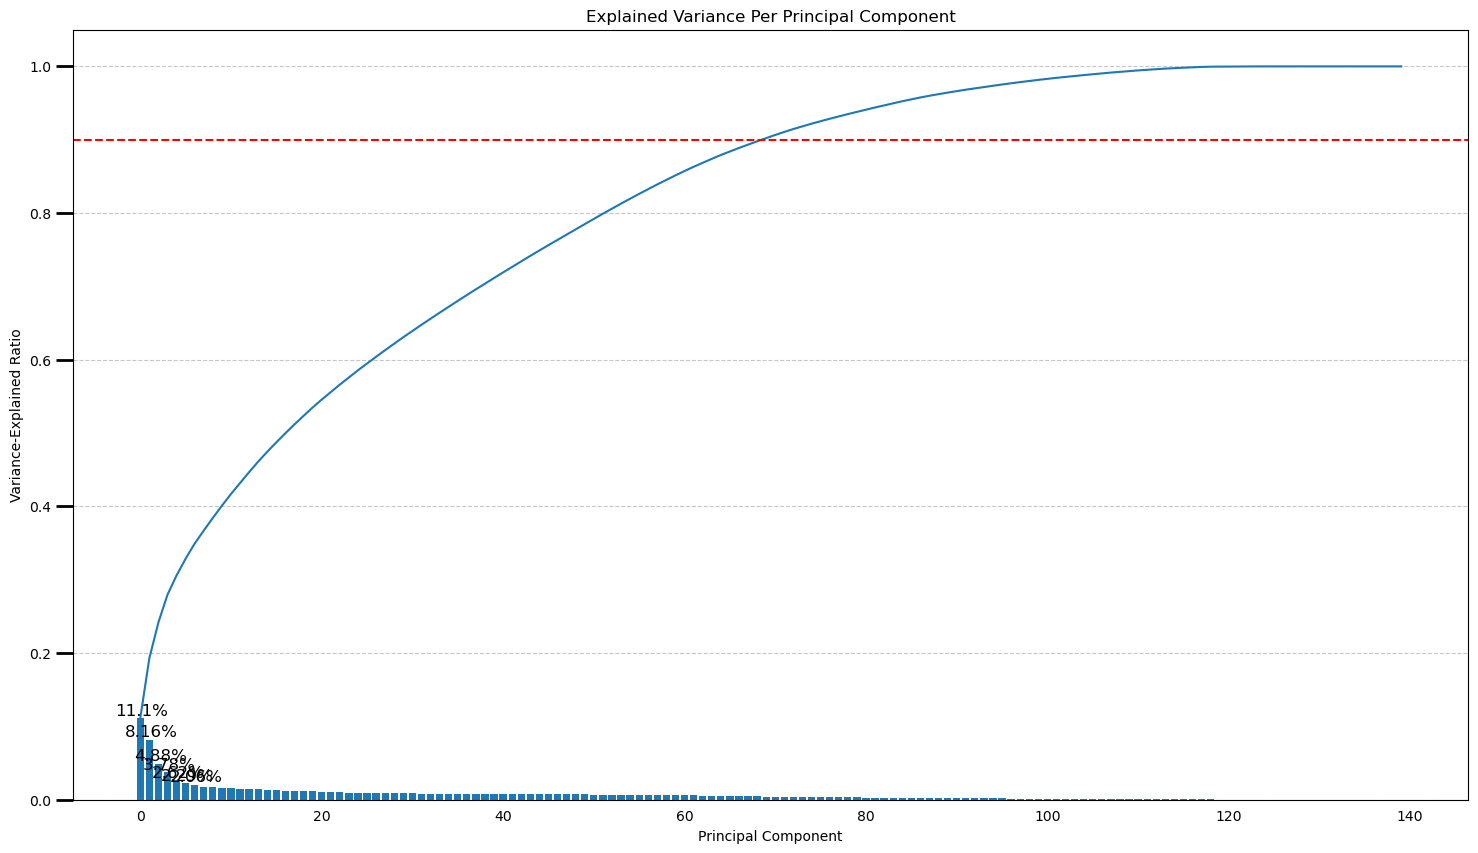

In [56]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [57]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=68)
pca.fit(scaled_df)

PCA(n_components=68)

### Discussion 2.2: Perform Dimensionality Reduction

I first apply principal component analysis on the data, without set any parameters, to investigate the ratio of variance explained by each principal component. From above plot, we can obeserve that with around 68 components 90% of the all variance can already be explained, indicated by the red line. SO I choose 68 as number of components for PCA.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [58]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def interpret_pca_component(pca, component_index, feature_names):
    """
    Print the sorted list of feature weights for a given principal component.
    
    Parameters:
        pca (PCA): Fitted PCA instance.
        component_index (int): Index of the principal component (0-based).
        feature_names (list or array): List of feature names.
    """
    # extract the weights (loadings) for the specified principal component
    component_weights = pca.components_[component_index]
    
    # create a DataFrame to hold feature names and their weights
    weights_df = pd.DataFrame({
        'Feature': feature_names,
        'Weight': component_weights
    })
    
    # sort by the absolute value of weights in descending order
    weights_df['AbsWeight'] = weights_df['Weight'].abs()
    sorted_weights = weights_df.sort_values(by='AbsWeight', ascending=False)
    
    print(f"Principal Component {component_index + 1}:")
    print(sorted_weights[['Feature', 'Weight']])

    return sorted_weights

In [59]:
feature_names = completed_df.columns
sorted_weights_comp1 = interpret_pca_component(pca, 0, feature_names)

Principal Component 1:
                      Feature    Weight
48                 MOBI_REGIO -0.202624
2           FINANZ_MINIMALIST -0.194925
89         LP_STATUS_GROB_1.0  0.194612
38                KBA05_ANTG1 -0.189512
52                 PLZ8_ANTG1 -0.181814
54                 PLZ8_ANTG3  0.181569
42                  KBA05_GBZ -0.180861
29         HH_EINKOMMEN_SCORE  0.179635
55                 PLZ8_ANTG4  0.176453
126                    Wealth  0.175746
56                PLZ8_BAUMAX  0.171858
60                ORTSGR_KLS9  0.155122
44                   EWDICHTE  0.153363
7            FINANZ_HAUSBAUER  0.145466
34                KONSUMNAEHE -0.134372
58                   PLZ8_GBZ -0.133691
45                 INNENSTADT -0.127649
41                KBA05_ANTG4  0.126304
79         LP_STATUS_FEIN_1.0  0.126258
53                 PLZ8_ANTG2  0.123270
3               FINANZ_SPARER  0.122018
68              FINANZTYP_1.0  0.116414
93         LP_STATUS_GROB_5.0 -0.115547
88        LP_STAT

In [60]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

sorted_weights_comp2 = interpret_pca_component(pca, 1, feature_names)

Principal Component 2:
                      Feature    Weight
124                    Decade -0.228858
0        ALTERSKATEGORIE_GROB  0.225767
3               FINANZ_SPARER -0.220105
4            FINANZ_VORSORGER  0.213495
6       FINANZ_UNAUFFAELLIGER -0.211310
13                  SEMIO_REL -0.210070
24                SEMIO_TRADV -0.203543
23              SEMIO_PFLICHT -0.200031
5              FINANZ_ANLEGER -0.199135
103              ZABEOTYP_3.0  0.198047
17                  SEMIO_ERL  0.177852
18                 SEMIO_KULT -0.162987
19                  SEMIO_RAT -0.162163
49          ONLINE_AFFINITAET -0.160447
10             RETOURTYP_BK_S  0.157839
16                 SEMIO_LUST  0.157481
129   LP_LEBENSPHASE_GROB_2.0  0.152684
12                  SEMIO_FAM -0.129027
68              FINANZTYP_1.0 -0.128673
14                  SEMIO_MAT -0.124327
30             W_KEIT_KIND_HH  0.114389
79         LP_STATUS_FEIN_1.0  0.105220
104              ZABEOTYP_4.0 -0.103350
63          CJT_G

In [61]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

sorted_weights_comp2 = interpret_pca_component(pca, 2, feature_names)

Principal Component 3:
                      Feature    Weight
1                   ANREDE_KZ -0.342825
15                 SEMIO_VERT  0.318635
22                 SEMIO_KAEM -0.311216
21                  SEMIO_DOM -0.277204
20                 SEMIO_KRIT -0.261073
12                  SEMIO_FAM  0.258615
11                  SEMIO_SOZ  0.256403
18                 SEMIO_KULT  0.247131
17                  SEMIO_ERL -0.203582
5              FINANZ_ANLEGER -0.154695
19                  SEMIO_RAT -0.153524
72              FINANZTYP_5.0  0.137699
2           FINANZ_MINIMALIST  0.132261
97            SHOPPER_TYP_0.0  0.118684
101              ZABEOTYP_1.0  0.116907
13                  SEMIO_REL  0.116000
68              FINANZTYP_1.0 -0.100865
99            SHOPPER_TYP_2.0 -0.099239
14                  SEMIO_MAT  0.085104
8            GREEN_AVANTGARDE  0.083277
125                  Movement  0.081693
82         LP_STATUS_FEIN_4.0 -0.081599
80         LP_STATUS_FEIN_2.0 -0.080368
10             RE

### Discussion 2.3: Interpret Principal Components

#### Principal Component 1 (PC1):
- Key Features:
    - Negative Weights: Low regional mobility (MOBI_REGIO), low financial activity (FINANZ_MINIMALIST), fewer family homes (PLZ8_ANTG1).
    - Positive Weights: Higher income (HH_EINKOMMEN_SCORE), more diverse family housing (PLZ8_ANTG3), low-income earners (LP_STATUS_GROB_1.0).
- Separates areas with low mobility and financial activity (negative) from more affluent, family-diverse regions (positive).
#### Principal Component 2 (PC2):
- Key Features:
    - Negative Weights: Older generations (Decade), traditional/religious values (SEMIO_TRADV, SEMIO_REL), financial savings (FINANZ_SPARER).
    - Positive Weights: Younger age groups (ALTERSKATEGORIE_GROB), eco-conscious households (ZABEOTYP_3.0).
- Interpretation: Contrasts older, traditional populations (negative) with younger, progressive, eco-conscious groups (positive).
#### Principal Component 3 (PC3):
- Key Features:
    - Negative Weights: Individualistic and critical behaviors (ANREDE_KZ, SEMIO_DOM, SEMIO_KRIT).
    - Positive Weights: Family- and socially-minded traits (SEMIO_FAM, SEMIO_SOZ).
- Interpretation:
Opposes assertive, individualistic traits (negative) with social and family-oriented tendencies (positive).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [62]:
from sklearn.cluster import KMeans
pca_transformed = pca.transform(scaled_df)
transformed_df = pd.DataFrame(pca_transformed, columns=[f'PC{i+1}' for i in range(68)])
print("Shape of transformed DataFrame:", transformed_df.shape)

Shape of transformed DataFrame: (747162, 68)


In [63]:
# Over a number of different cluster counts...
cluster_counts = list(range(2, 31, 3))  
inertias = []   

# run k-means clustering on the data and...
# compute the average within-cluster distances.
pca_data = transformed_df.values
for k in cluster_counts:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_data)
    inertias.append(-kmeans.score(pca_data))
    print(k, -kmeans.score(pca_data))    

2 84483263.81831919
5 75461853.73800871
8 70809329.1732867
11 67802641.01088491
14 65732424.1273848
17 64270452.837785326
20 62332079.48264156
23 61184397.78519862
26 59545695.965754464
29 58132175.85449618


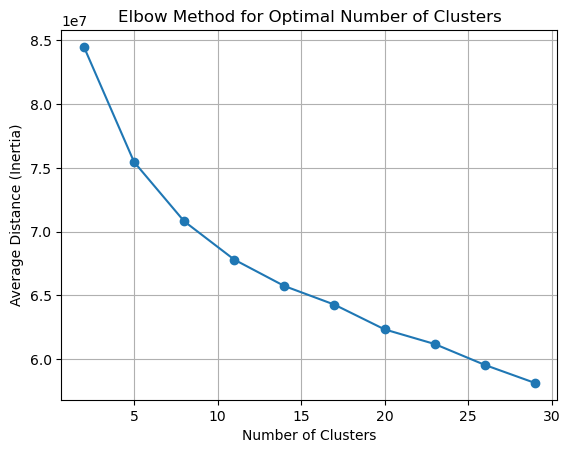

In [64]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(cluster_counts, inertias, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Average Distance (Inertia)")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.grid()
plt.show()

In [65]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
final_k = 8
final_kmeans = KMeans(n_clusters=final_k, random_state=42)
final_kmeans.fit(pca_data)
gene_cluster_assignments = final_kmeans.labels_

transformed_df['Cluster'] = gene_cluster_assignments
print("Cluster assignments added to PCA-transformed data.")

Cluster assignments added to PCA-transformed data.


### Discussion 3.1: Apply Clustering to General Population
I investigate the perfermance of K-Means with (2, 30) clusters. And I find, after k=8 the reduction in inertia is relatively small, which is significantly lower than the reductions for previous cluster counts. And this indicates `k=8` could be a saturation point where adding more clusters stops significantly improving the model.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [66]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
print(customers.shape)
customers.head()

(191652, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [67]:
cleaned_customers = clean_data(customers)

In [68]:
print(cleaned_customers.shape)
print(cleaned_customers.isna().any().sum())

(133477, 140)
0


In [69]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
# Align cleaned_customers to match the column order of gene_df
cleaned_customers = cleaned_customers[completed_df.columns]
scaled_customers = sd_scaler.transform(cleaned_customers)

# pca transformation
pca_transformed_customers = pca.transform(scaled_customers)
transformed_customers = pd.DataFrame(pca_transformed_customers, columns=[f'PC{i+1}' for i in range(68)])
pca_customers = transformed_customers.values

# clustering
final_kmeans_cus = KMeans(n_clusters=final_k, random_state=42)
final_kmeans_cus.fit(pca_customers)
cluster_assignments_cus = final_kmeans_cus.labels_

transformed_customers['Cluster'] = cluster_assignments_cus
cluster_counts = transformed_customers['Cluster'].value_counts()
print(cluster_counts)

Cluster
2    28742
6    25982
1    21634
3    18326
4    18068
0    11946
5     6200
7     2579
Name: count, dtype: int64


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

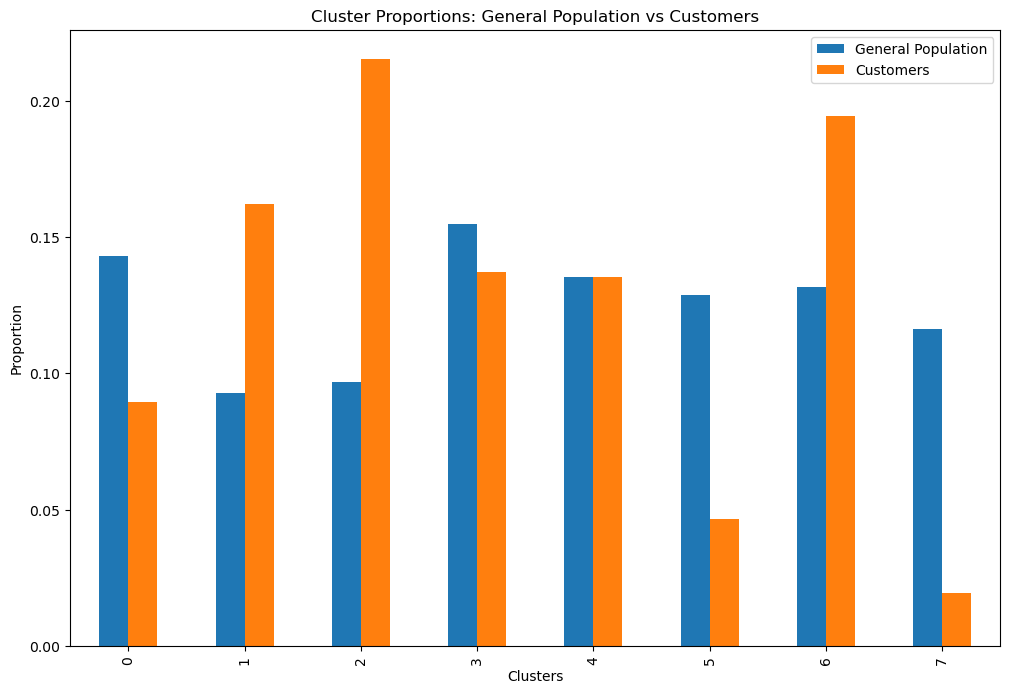

In [70]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

gen_cluster_counts = transformed_df['Cluster'].value_counts(normalize=True)
cust_cluster_counts = transformed_customers['Cluster'].value_counts(normalize=True)
# Combine for Comparison
cluster_comparison = pd.DataFrame({
    'General Population': gen_cluster_counts,
    'Customers': cust_cluster_counts
}).fillna(0)

cluster_comparison.plot(kind='bar', figsize=(12, 8))
plt.title("Cluster Proportions: General Population vs Customers")
plt.ylabel("Proportion")
plt.xlabel("Clusters")
plt.show()

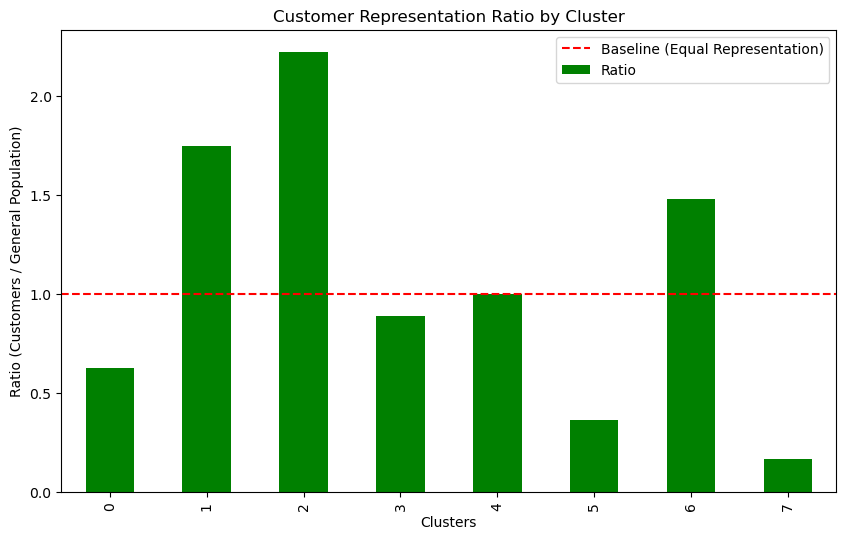

In [71]:
# a column for the ratio of customer proportions to general population proportions
cluster_comparison['Ratio'] = cluster_comparison['Customers'] / cluster_comparison['General Population']

cluster_comparison['Ratio'].plot(kind='bar', color='green', figsize=(10, 6))
plt.title("Customer Representation Ratio by Cluster")
plt.ylabel("Ratio (Customers / General Population)")
plt.xlabel("Clusters")
plt.axhline(y=1, color='red', linestyle='--', label='Baseline (Equal Representation)')
plt.legend()
plt.show()


In [72]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Clusters with a Ratio > 1.2 in the cluster_comparison DataFrame
overrepresented_clusters = cluster_comparison[cluster_comparison['Ratio'] > 1.2]

# identify the clusters centroid
overrepresented_centroids = final_kmeans_cus.cluster_centers_[overrepresented_clusters.index]
original_features = sd_scaler.inverse_transform(pca.inverse_transform(overrepresented_centroids))
centroids_df = pd.DataFrame(original_features, columns=completed_df.columns, index=overrepresented_clusters.index)
print(centroids_df.index)

Index([1, 2, 6], dtype='int32', name='Cluster')


In [73]:
for cluster_idx, true_cluster_idx in enumerate(overrepresented_clusters.index):
    print(cluster_idx, true_cluster_idx)

0 1
1 2
2 6


In [74]:
# Find the top 5 important features for each overrepresented cluster
top_features = {}
for cluster_idx, true_cluster_idx in enumerate(overrepresented_clusters.index):
    # Access the centroid for the current cluster
    centroid = overrepresented_centroids[cluster_idx]
    
    # Compute the importance of each feature for this cluster
    pc_importance = abs(centroid @ pca.components_)  # Combine PC weights with centroid values
    
    # Get indices of the top 5 important features
    important_features_idx = pc_importance.argsort()[-5:][::-1]  # Sort and select top 5 features
    
    # Store the results with the true cluster index
    top_features[f"Cluster {true_cluster_idx}"] = completed_df.columns[important_features_idx].tolist()


for cluster, features in top_features.items():
    print(f"{cluster}: Top Features: {', '.join(features)}")


Cluster 1: Top Features: LP_STATUS_GROB_5.0, LP_STATUS_FEIN_10.0, GREEN_AVANTGARDE, Movement, LP_LEBENSPHASE_GROB_5.0
Cluster 2: Top Features: LP_STATUS_FEIN_9.0, LP_STATUS_GROB_4.0, FINANZ_MINIMALIST, LP_LEBENSPHASE_GROB_12.0, ORTSGR_KLS9
Cluster 6: Top Features: LP_LEBENSPHASE_GROB_12.0, LP_STATUS_FEIN_10.0, LP_STATUS_GROB_5.0, GREEN_AVANTGARDE, Movement


In [75]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

underrepresented_clusters = cluster_comparison[cluster_comparison['Ratio'] < 0.8]

# Identify the centroids of the underrepresented clusters
underrepresented_centroids = final_kmeans_cus.cluster_centers_[underrepresented_clusters.index]
original_features = sd_scaler.inverse_transform(pca.inverse_transform(underrepresented_centroids))
centroids_df = pd.DataFrame(original_features, columns=completed_df.columns, index=underrepresented_clusters.index)
print("Underrepresented Cluster Indices:", centroids_df.index)

top_features = {}
for cluster_idx, true_cluster_idx in enumerate(underrepresented_clusters.index):
    centroid = underrepresented_centroids[cluster_idx]
    
    pc_importance = abs(centroid @ pca.components_)  # Combine PC weights with centroid values
    
    important_features_idx = pc_importance.argsort()[-5:][::-1]  # Sort and select top 5 features
    
    top_features[f"Cluster {true_cluster_idx}"] = completed_df.columns[important_features_idx].tolist()

for cluster, features in top_features.items():
    print(f"{cluster}: Top Features: {', '.join(features)}")


Underrepresented Cluster Indices: Index([0, 5, 7], dtype='int32', name='Cluster')
Cluster 0: Top Features: LP_STATUS_GROB_3.0, LP_STATUS_FEIN_7.0, LP_STATUS_FEIN_6.0, ANZ_TITEL, LP_LEBENSPHASE_GROB_12.0
Cluster 5: Top Features: LP_LEBENSPHASE_GROB_8.0, LP_FAMILIE_GROB_4.0, W_KEIT_KIND_HH, FINANZ_HAUSBAUER, HH_EINKOMMEN_SCORE
Cluster 7: Top Features: LP_STATUS_FEIN_7.0, ANZ_TITEL, ANZ_HH_TITEL, LP_STATUS_GROB_3.0, Movement


### Discussion 3.3: Compare Customer Data to Demographics Data
#### Overrepresented Clusters
- Cluster 0: Popular among older, eco-conscious individuals (LP_LEBENSPHASE_GROB_12.0, GREEN_AVANTGARDE) with stable socioeconomic status, indicating strong engagement with sustainable and practical products.
- Cluster 3: Includes financially mindful customers (FINANZ_MINIMALIST) in moderate socioeconomic groups, and an established but less affluent socioeconomic status (LP_STATUS_GROB_4.0). They value affordability and practicality, aligning with the company’s offerings.
#### Underrepresented Clusters
- Cluster 6: Represents younger, lower-socioeconomic individuals (CAMEO_DEUG_2015_1, LP_STATUS_GROB_3.0) who may lack purchasing power or alignment with the company’s products.
- Cluster 7: Although similar to some overrepresented clusters in features like LP_STATUS_GROB_5.0 and GREEN_AVANTGARDE, this group may differ in geographic or lifestyle factors (CAMEO_DEUG_2015_1),  indicating potential gaps in product appeal or marketing strategies.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.